In [4]:
import ee 
import geemap
import pandas as pd
import geopandas as gpd
import ltgee
from datetime import date
import ipyleaflet
import rioxarray as rxr

In [2]:
ee.Authenticate()

True

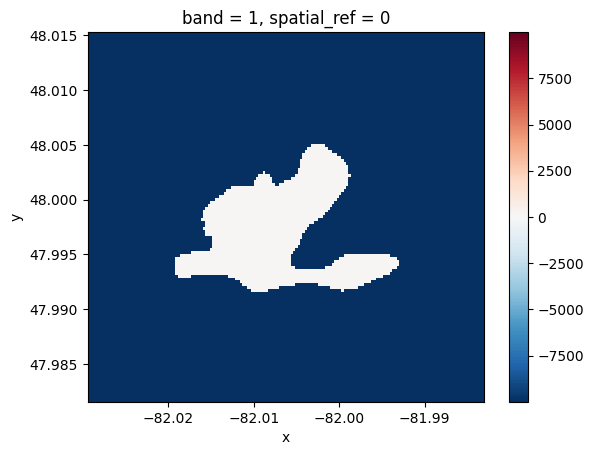

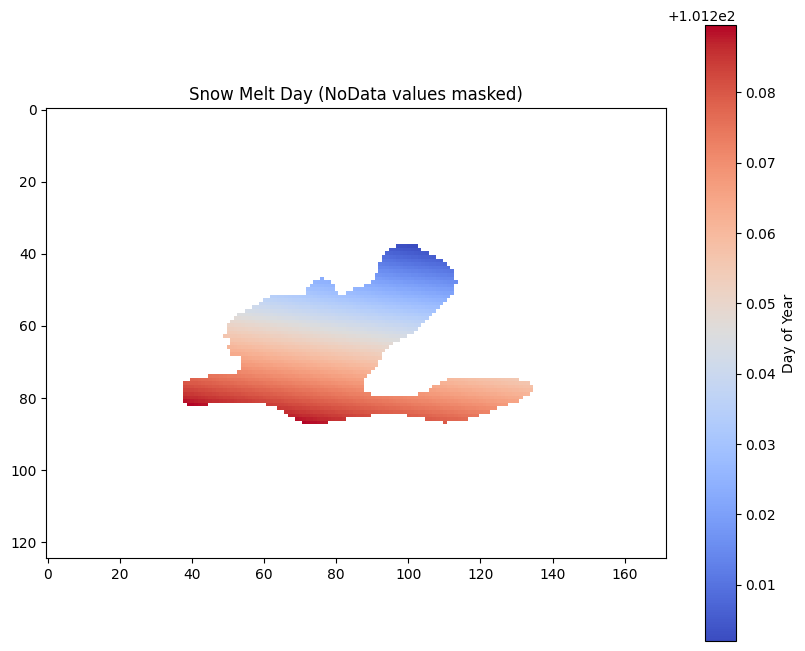

In [11]:
# import tif using rioxarray
import matplotlib.pyplot as plt
raster_data = rxr.open_rasterio("/Users/jgoldman/Work/PhD/time-lagged-moisture-project/data/fire_snow_melt/snow_melt_fire_2308.0_2021.0.tif")
raster_data.plot()
plt.show()
values = raster_data.values

# You can also create a masked array for visualization
masked_values = np.ma.masked_where(values == -9999, values)

# Plot the masked array
plt.figure(figsize=(10, 8))
plt.imshow(masked_values[0], cmap='coolwarm')
plt.colorbar(label='Day of Year')
plt.title('Snow Melt Day (NoData values masked)')
plt.show()

In [3]:
ee.Initialize(project="ee-jandrewgoldman")

In [4]:
shield = ee.FeatureCollection("users/jandrewgoldman/Ontario_Shield_v0")

In [22]:
nbac =ee.FeatureCollection("projects/sat-io/open-datasets/CA_FOREST/NBAC/nbac_1972_2023_20240530").filter(ee.Filter.eq("ADMIN_AREA", "ON")).filter(ee.Filter.gte("YEAR", 1985)) 


In [ ]:
nbac_size = nbac.size().getInfo()
print(f"NBAC Ontario FeatureCollection size: {nbac_size}")


NBAC Ontario FeatureCollection size: 2805


In [35]:
# Print all properties of the first feature
first_feature = nbac.first()
print("Properties of the first feature:")
for property_name, property_value in first_feature.getInfo()['properties'].items():
    print(f"{property_name}: {property_value}")


Properties of the first feature:
ADJ_FLAG: true
ADJ_HA: 41.9652645384
ADMIN_AREA: ON
AG_EDATE: 956905200000
AG_SDATE: 956646000000
BASRC: Agency
CAPDATE: None
FIRECAUS: Human
FIREMAPM: Buffered points
FIREMAPS: Undefined
GID: 2000_529
HS_EDATE: None
HS_SDATE: None
NATPARK: 
NFIREID: 529
POLY_HA: 44.8099564591
PRESCRIBED: 
VERSION: 20240530
YEAR: 2000


In [25]:
# Clip the shield FeatureCollection to the nbac FeatureCollection
nbac_shield = nbac.filterBounds(shield.geometry())

In [26]:
nbac_shield_size = nbac_shield.size().getInfo()
print(f"NBAC Ontario Shield FeatureCollection size: {nbac_shield_size}")

NBAC Ontario Shield FeatureCollection size: 2288


In [28]:

# For a more precise clip, you can also use:
# clipped_shield = shield.map(function(feature) {
#   return feature.intersection(nbac.geometry());
# })

# Visualize the result
m = geemap.Map()
m.add_layer(nbac_shield, {}, 'Clipped Shield')
m.add_layer(nbac, {'color': 'blue'}, 'NBAC Ontario', False)
m.center_object(ee.Geometry.Point([-85, 50]), 5)  # Approximate center of Ontario
m

Map(center=[49.99999999999999, -85], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Se…

For NBAC shield, lets get VPD

In [30]:
#print the all levels of values of a property in the nbac_shield FeatureCollection
def get_unique_values(feature_collection, property_name):
    # Get the unique values of a property in a FeatureCollection
    unique_values = feature_collection.aggregate_array(property_name).getInfo()
    return set(unique_values)

# Get the unique values of the "SPECIES" property  
unique_cause = get_unique_values(nbac_shield, "FIRECAUS")
print("Unique values of the 'FIRE_CAUSE' property in the nbac_shield FeatureCollection:")
for value in unique_cause:
    print(value)

Unique values of the 'FIRE_CAUSE' property in the nbac_shield FeatureCollection:
Human
Undetermined
Natural


remove all human and undetermined

In [32]:
nbac_shield_natural = nbac_shield.filter(ee.Filter.eq("FIRECAUS", "Natural"))
nbac_shield_natural_size = nbac_shield_natural.size().getInfo()
print(f"NBAC Ontario Shield FeatureCollection size with natural fire cause: {nbac_shield_natural_size}")

NBAC Ontario Shield FeatureCollection size with natural fire cause: 1394


In [33]:
nbac_shield_undetermined  = nbac_shield.filter(ee.Filter.eq("FIRECAUS", "Undetermined"))
nbac_shield_undetermined_size = nbac_shield_undetermined.size().getInfo()
print(f"NBAC Ontario Shield FeatureCollection size with undetermined fire cause: {nbac_shield_undetermined_size}")

NBAC Ontario Shield FeatureCollection size with undetermined fire cause: 664


Remove all fires greater than 50ha

In [36]:
nbac_shield_nat_gt50 = nbac_shield_natural.filter(ee.Filter.gte("POLY_HA", 50))
nbac_shield_nat_gt50_size = nbac_shield_nat_gt50.size().getInfo()
print(f"NBAC Ontario Shield FeatureCollection size with natural fire cause and greater than 50 hectares: {nbac_shield_nat_gt50_size}")

NBAC Ontario Shield FeatureCollection size with natural fire cause and greater than 50 hectares: 1322


GET AGENCY START DATE AS YMD

In [39]:
# get AG_SDATE as date object YMD
def convert_to_date(feature):
    ag_sdate = feature.get('AG_SDATE')
    # Convert to ee.Date and format as YYYY-MM-DD
    date_object = ee.Date(ag_sdate)
    formatted_date = date_object.format('YYYY-MM-dd')
    month = date_object.get('month')
    
    # Set both the original date and formatted date as properties
    return feature.set({
        'AG_SDATE': date_object,
        'AG_SDATE_YMD': formatted_date,
        'FIRE_MONTH': month 
    })
nbac_shield_nat_gt50 = nbac_shield_nat_gt50.map(convert_to_date)

for property_name, property_value in nbac_shield_nat_gt50.first().getInfo()['properties'].items():
    print(f"{property_name}: {property_value}")

ADJ_FLAG: true
ADJ_HA: 66.6419217477
ADMIN_AREA: ON
AG_EDATE: 1534575600000
AG_SDATE: {'type': 'Date', 'value': 1531897200000}
AG_SDATE_YMD: 2018-07-18
BASRC: Agency
FIRECAUS: Natural
FIREMAPM: Undefined
FIREMAPS: Undefined
FIRE_MONTH: 7
GID: 2018_1084
HS_EDATE: 1532156400000
HS_SDATE: 1532156400000
NATPARK: 
NFIREID: 1084
POLY_HA: 72.4925677237
PRESCRIBED: 
VERSION: 20240530
YEAR: 2018


Get ERA VPD for each month prior to fire